# 🏙️ CityPulse 

Welcome to **CityPulse**, a project to detect unusual city behavior using real-time sensor data.  
This first part sets up the foundation by simulating how sensor data might look in a real smart city.





# 📊 CityPulse – Part 1: Building Baseline Behavior Models

---

## 🧠 What’s the Goal?

To detect **anomalies** in urban sensor data, we first need to understand what “normal” looks like.

This part focuses on building **baseline models** — or in simple terms, calculating the **usual/expected values** of different urban metrics.

---

## 🔍 What is a Baseline?

A **baseline** is the typical behavior of a metric (like traffic or noise) depending on:
- 🕒 **Hour of the day** (0 to 23)
- 📆 **Day of the week** (Monday = 0, Sunday = 6)
- 🗺️ **Zone** (Sector 1 to Sector 100)

Once we know these typical patterns, we can later spot abnormal values — which become our **anomalies**.

---

## 📁 Step 1: Load the Data

We begin by loading the CSV file we created earlier. This file contains sensor readings like traffic, noise, pollution, power usage, and foot traffic — recorded every hour for every sector.

We also convert the timestamp into proper datetime format so we can extract hour and weekday.

---

## 🧮 Step 2: Extract Time Features

From the timestamp, we pull out:
- `hour`: to understand daily cycles
- `weekday`: to capture differences between weekdays and weekends

This helps in building more accurate baselines because patterns vary by time.

---

## 📏 Step 3: Focus on the Right Metrics

We’re analyzing 6 metrics:
1. `traffic_density`
2. `noise_level`
3. `pm2_5`
4. `pm10`
5. `power_usage`
6. `foot_traffic`

These are the key indicators of urban activity and environment that we want to monitor for anomalies.

---

## 🔄 Step 4: Reshape the Data

To make the data easier to analyze, we change its shape from **wide format** (with multiple columns for each metric) to **long format** (one column for metric names, one for their values).

This allows us to apply grouped statistical operations across all metrics more efficiently.

---

## 📊 Step 5: Calculate Averages and Variability

For each combination of:
- zone
- hour
- weekday
- metric

We calculate:
- `mean`: the average value
- `std`: standard deviation (how much it usually varies)

These values form our **baseline behavior model** — the normal, expected range for each metric.

---

## ✅ What Do We Have Now?

We now have a clean DataFrame of baselines showing, for example:
- What is the average `traffic_density` on Mondays at 9 AM in Sector 42?
- How much does `noise_level` vary at midnight in Sector 5 on Fridays?

This information will allow us to flag **unusual activity** later — like a sudden spike in pollution or silence in a normally noisy area.




In [19]:
import pandas as pd

# Load your full dataset
df = pd.read_csv('.Project/simulated_urban_sensor_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

metrics = ['traffic_density', 'noise_level', 'pm2_5', 'pm10', 'power_usage', 'foot_traffic']

# Melt the DataFrame to long format for grouped aggregation
melted = df.melt(id_vars=['zone', 'hour', 'weekday'], value_vars=metrics,
                 var_name='metric', value_name='value')

# Group and compute mean + std
baseline_stats = melted.groupby(['zone', 'hour', 'weekday', 'metric'])['value'].agg(['mean', 'std']).reset_index()

# Rename for clarity
baseline_stats.columns = ['zone', 'hour', 'weekday', 'metric', 'mean', 'std']
baseline_stats

,zone,hour,weekday,metric,mean,std
0,Sector 1,0,0,foot_traffic,232.500000,11.210114
1,Sector 1,0,0,noise_level,66.303853,1.823624
2,Sector 1,0,0,pm10,67.992419,13.728567
3,Sector 1,0,0,pm2_5,36.400800,1.916073
4,Sector 1,0,0,power_usage,1210.070484,357.170371
...,...,...,...,...,...,...
100795,Sector 99,23,6,noise_level,67.715464,4.912756
100796,Sector 99,23,6,pm10,58.992078,21.386294
100797,Sector 99,23,6,pm2_5,29.407506,9.265308
100798,Sector 99,23,6,power_usage,1168.592825,262.152217


In [20]:
baseline_stats #.to_csv('baseline_model.csv', index=False)

,zone,hour,weekday,metric,mean,std
0,Sector 1,0,0,foot_traffic,232.500000,11.210114
1,Sector 1,0,0,noise_level,66.303853,1.823624
2,Sector 1,0,0,pm10,67.992419,13.728567
3,Sector 1,0,0,pm2_5,36.400800,1.916073
4,Sector 1,0,0,power_usage,1210.070484,357.170371
...,...,...,...,...,...,...
100795,Sector 99,23,6,noise_level,67.715464,4.912756
100796,Sector 99,23,6,pm10,58.992078,21.386294
100797,Sector 99,23,6,pm2_5,29.407506,9.265308
100798,Sector 99,23,6,power_usage,1168.592825,262.152217


# 🚨 CityPulse – Part 2: Anomaly Detection Using Z-Score

---

## 🧠 What’s the Goal?

Now that we’ve built our baseline behavior models, it’s time to actually **detect anomalies** in our data.

In this section, we use a very simple and powerful statistical method: the **Z-score**.

---

## ❓ What Is a Z-Score?

A **z-score** tells us **how far a data point is from the average**, measured in units of standard deviation.

- If a value is close to the mean → z-score ≈ 0  
- If it’s unusually high or low → z-score > 2 or < -2  
- If it’s very far from the norm (e.g. > 3 std dev) → likely an **anomaly**

---

## 🔍 What We’re Doing

We apply z-score anomaly detection to one metric: `noise_level`.

The steps:
1. Compute the **mean** and **standard deviation** of `noise_level`
2. For every data point, compute its **z-score**
3. If the z-score is **greater than +3 or less than -3**, we **flag it as an anomaly**

This helps us find places and times where the noise level is **abnormally high or abnormally low** — which could mean:
- A **protest** or **construction** site (loud)
- An **unexpected blackout** or **quiet zone** (silent)

---

## ✅ What We Get

We create two new columns:
- `noise_zscore`: shows how unusual each value is
- `noise_anomaly`: a True/False flag that tells us if that point is anomalous

This is a foundational technique — we can repeat it later for other metrics like pollution, traffic, etc.




In [22]:
import numpy as np

# Example: z-score for noise_level
df['noise_zscore'] = (df['noise_level'] - df['noise_level'].mean()) / df['noise_level'].std()
df['noise_anomaly'] = df['noise_zscore'].abs() > 3

# 🌐 CityPulse – Part 3: Detecting & Grouping Anomalies Across the City

---

## 🧠 Goal

In this part, we move beyond just individual anomaly points.

We now:
1. Use **Isolation Forest** to detect multivariate anomalies (based on all metrics).
2. Use **DBSCAN** clustering to group anomalies that are close in **space** and **time**.
3. Summarize them as **urban events** — for example:  
   🚨 "Traffic surge in Sector 4, 5, and 6 between 3:00 PM and 5:00 PM"

---

## ⚙️ Step 1: Isolation Forest – Multivariate Anomaly Detection

**What it does:**  
Isolation Forest is a machine learning model that can detect **unusual combinations** of values across many features.

**Why it’s better than z-score here:**  
Z-score only works on one metric at a time. Isolation Forest can spot strange patterns across multiple sensors like:
- High traffic + low noise + low power usage = anomaly  
- Low foot traffic + high PM2.5 = anomaly

**How we use it:**
- We take all numeric features: traffic, pollution, noise, power, foot traffic
- We scale the data and apply Isolation Forest
- It returns:
  - `1` for normal
  - `-1` for anomaly

---

## 🗺️ Step 2: DBSCAN – Spatiotemporal Clustering of Anomalies

**What it does:**  
DBSCAN is a clustering algorithm that groups **dense blobs of points** based on distance (space and time).

**Why we use it here:**
Even if we detect hundreds of anomalies, we don’t want to see them individually.

We want to **cluster them** into events like:
- “All these zones had high traffic around the same time” = 🚨 one event

**How we do it:**
- For each anomaly, we extract:
  - `lat`, `lon`: for spatial closeness
  - `timestamp` (as seconds): for time similarity
  - one sensor value (e.g. `traffic_density`)
- Scale and cluster using DBSCAN

Result: each anomaly is labeled as part of an `event_cluster`

---

## 📝 Step 3: Summarize Events

We now take all valid event clusters and summarize them:
- **zones**: all affected areas
- **start_time** and **end_time**: when it happened
- **avg_traffic_density**: how intense the traffic was (as an example)
- **description**: a natural language sentence like:

> 🚨 Traffic surge in Sector 7, Sector 8 from 14:00 to 16:00

This turns raw sensor anomalies into **human-readable urban events**.

---

## ✅ What We Achieved

We now have a working engine that:
- Detects multivariate anomalies
- Groups them in time and space
- Labels them with meaningful summaries

This powers the heart of **CityPulse** — an intelligent urban monitoring system.




In [23]:
from sklearn.ensemble import IsolationForest

# Select numeric features only
features = ['traffic_density', 'noise_level', 'pm2_5', 'pm10', 'power_usage', 'foot_traffic']
X = df[features]

iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['iso_anomaly'] = iso_forest.fit_predict(X)  # -1 for anomaly, 1 for normal

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler



coords = df[['lat', 'lon']]
X = StandardScaler().fit_transform(coords)

db = DBSCAN(eps=0.3, min_samples=5)
df['dbscan_label'] = db.fit_predict(X)

In [25]:
df['is_anomaly'] = (
    (df['noise_anomaly']) |
    (df['iso_anomaly'] == -1) |
    (df['dbscan_label'] == -1)
)

In [26]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour_of_day'] = df['timestamp'].dt.hour
df['time_encoded'] = df['timestamp'].astype(np.int64) // 10**9  # seconds

# Assume df already has 'lat', 'lon', and one metric: e.g., 'traffic_density'
anomalies = df[df['iso_anomaly'] == -1].copy()
from sklearn.cluster import DBSCAN

features = anomalies[['time_encoded', 'lat', 'lon', 'traffic_density']]
scaled = StandardScaler().fit_transform(features)

# DBSCAN for spatiotemporal grouping
dbscan = DBSCAN(eps=1.5, min_samples=3)
anomalies['event_cluster'] = dbscan.fit_predict(scaled)

In [27]:
event_summary = (
    anomalies[anomalies['event_cluster'] != -1]
    .groupby('event_cluster')
    .agg({
        'zone': lambda x: list(sorted(set(x))),
        'timestamp': ['min', 'max'],
        'traffic_density': 'mean'
    })
)

event_summary.columns = ['zones', 'start_time', 'end_time', 'avg_traffic_density']
event_summary.reset_index(inplace=True)

# Add descriptions
event_summary['description'] = event_summary.apply(
    lambda row: f"🚨 Traffic surge in {', '.join(row['zones'])} from {row['start_time']} to {row['end_time']}",
    axis=1
)

In [28]:
df


,timestamp,zone,traffic_density,noise_level,pm2_5,pm10,power_usage,foot_traffic,lat,lon,hour,weekday,noise_zscore,noise_anomaly,iso_anomaly,dbscan_label,is_anomaly,hour_of_day,time_encoded
0,2025-01-01 00:00:00,Sector 1,164.901425,64.308678,41.476885,92.845448,1129.753988,255,26.769354,83.380140,0,2,-0.083378,False,1,0,False,0,1735689600
1,2025-01-01 01:00:00,Sector 1,142.975891,62.095609,29.748302,61.429298,922.775149,251,26.769354,83.380140,1,2,-0.447209,False,1,0,False,1,1735693200
2,2025-01-01 02:00:00,Sector 1,122.759278,57.938481,49.656488,66.613355,1220.258461,254,26.769354,83.380140,2,2,-1.130645,False,1,0,False,2,1735696800
3,2025-01-01 03:00:00,Sector 1,107.257554,61.998731,44.474398,74.365510,1009.332078,247,26.769354,83.380140,3,2,-0.463136,False,1,0,False,3,1735700400
4,2025-01-01 04:00:00,Sector 1,174.676347,58.895782,37.088636,40.604948,801.544185,254,26.769354,83.380140,4,2,-0.973264,False,1,0,False,4,1735704000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,2025-01-30 19:00:00,Sector 100,150.766087,60.219972,47.144154,85.015490,1220.743170,251,26.754812,83.345719,19,3,-0.755565,False,1,31,False,19,1738263600
71996,2025-01-30 20:00:00,Sector 100,101.205547,63.250422,39.736879,66.571916,972.202329,259,26.754812,83.345719,20,3,-0.257356,False,1,31,False,20,1738267200
71997,2025-01-30 21:00:00,Sector 100,170.406753,69.647636,42.400891,97.901020,1362.248196,235,26.754812,83.345719,21,3,0.794352,False,1,31,False,21,1738270800
71998,2025-01-30 22:00:00,Sector 100,150.992274,75.275567,30.608831,40.479112,778.816566,247,26.754812,83.345719,22,3,1.719590,False,1,31,False,22,1738274400


In [29]:
df.to_csv('simulated_urban_s.csv', index=False)

# 📊 CityPulse – Part 4: Visualizing Sensor Trends for a Specific Zone

---

## 🎯 Goal

Before we move to map-based visualizations, it's helpful to **plot trends for a single zone** over time.

This helps us visually understand:
- What normal daily patterns look like (e.g., rush hours)
- When anomalies may have occurred (e.g., spikes or drops)

---

## 🗺️ What This Visualization Shows

We're plotting **two important metrics** over time for one sector:
- **Traffic Density** (cars/hour)
- **Noise Level** (decibels)

These trends are shown for a single zone — in this example, `"Sector 78"` — over 30 days.

---

## 🔍 What the Plot Tells Us

You’ll likely observe:
- **Morning and evening spikes** in traffic (typical rush hours)
- **Higher noise levels** aligning with traffic surges
- **Sudden dips or spikes** could indicate anomalies, such as:
  - Protests
  - Roadblocks
  - Construction
  - Accidents
  - Power outages (causing silence)

---

## 🛠️ Customization Tips

You can:
- Change `"Sector 78"` to any other zone (e.g., `"Sector 25"`)
- Add more sensor metrics (like `pm2_5`, `power_usage`)
- Overlay anomaly flags (e.g., highlight where z-score or Isolation Forest marked anomalies)

---

## ✅ Why It’s Useful

This plot gives a **quick local overview** of what's happening in a specific part of the city.

It’s a great **debugging tool** and a way to **verify if your anomaly detection is working correctly**.

---

📦 Next: Create a real-time dashboard or city-wide heatmap 🗺️


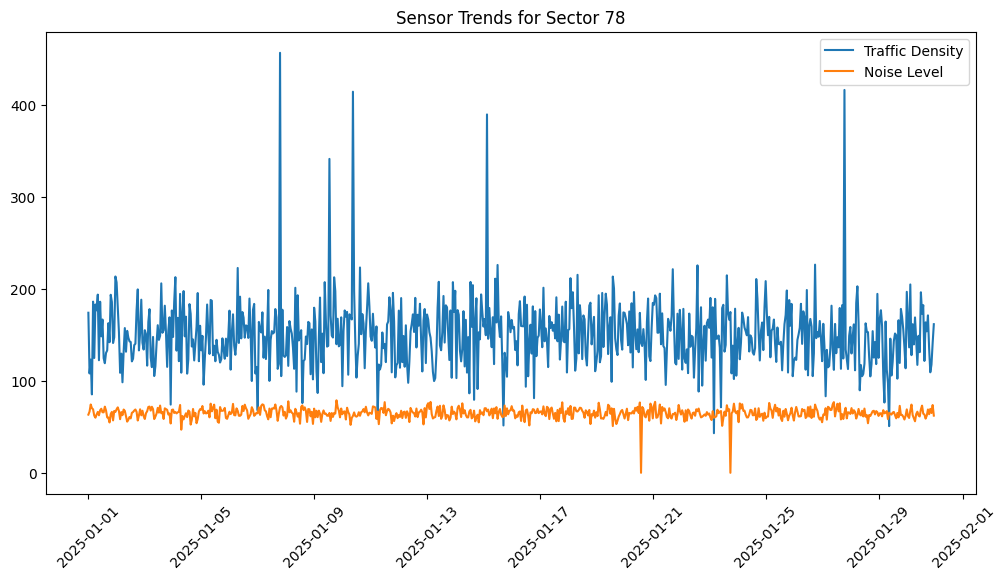

In [30]:
plt.figure(figsize=(12, 6))
selected_zone = "Sector 78"  # You can loop this for different sectors
zone_data = df[df['zone'] == selected_zone]

plt.plot(zone_data['timestamp'], zone_data['traffic_density'], label="Traffic Density")
plt.plot(zone_data['timestamp'], zone_data['noise_level'], label="Noise Level")
plt.legend()
plt.xticks(rotation=45)
plt.title(f"Sensor Trends for {selected_zone}")
plt.show()

# 🚨 CityPulse – Part 5: Highlighting Traffic Anomalies in a Specific Zone

---

## 🎯 Goal

Now that we’ve detected anomalies using Isolation Forest, let’s **visualize where those anomalies actually occur** — for example, **spikes in traffic** in a given sector.

This helps us validate:
- Whether our anomaly detection makes sense
- How traffic patterns deviate from normal behavior
- When those deviations occur

---

## 🔍 What This Plot Shows

We focus on one zone: `Sector 78`.

- **Blue dots** represent **normal traffic** data.
- **Red dots** mark **anomalous traffic points** — based on our earlier Isolation Forest model.

These anomalies could mean:
- A **sudden traffic jam**
- A **road closure**
- An **unusual event** (e.g., VIP movement, marathon)

---

## 🧠 How It Works

1. `anomalies = df[df['iso_anomaly'] == -1]`  
   → Selects all rows labeled as anomalies.

2. `highlight = anomalies[anomalies['zone'] == selected_zone]`  
   → Filters only anomalies for `"Sector 78"`.

3. We then **scatter-plot** all traffic values:
   - Normal points in blue
   - Anomalous points in red

---

## 📌 Interpretation Example

If you see a red spike far above the normal traffic dots, it means:
> "Traffic density in Sector 78 was much higher than usual at that time."

If the red point is low:
> "Traffic was unusually low (could indicate lockdown, road block, etc.)"

---

## 🛠️ Tips for Customization

- Try other zones: change `selected_zone = "Sector 25"` etc.
- Plot anomalies for other metrics like `noise_level`, `foot_traffic`, etc.
- Add vertical lines for events, e.g., known festivals or accidents

---

✅ This visualization is a key step in building **trustworthy anomaly detection systems** by letting humans **see and verify** the patterns directly.


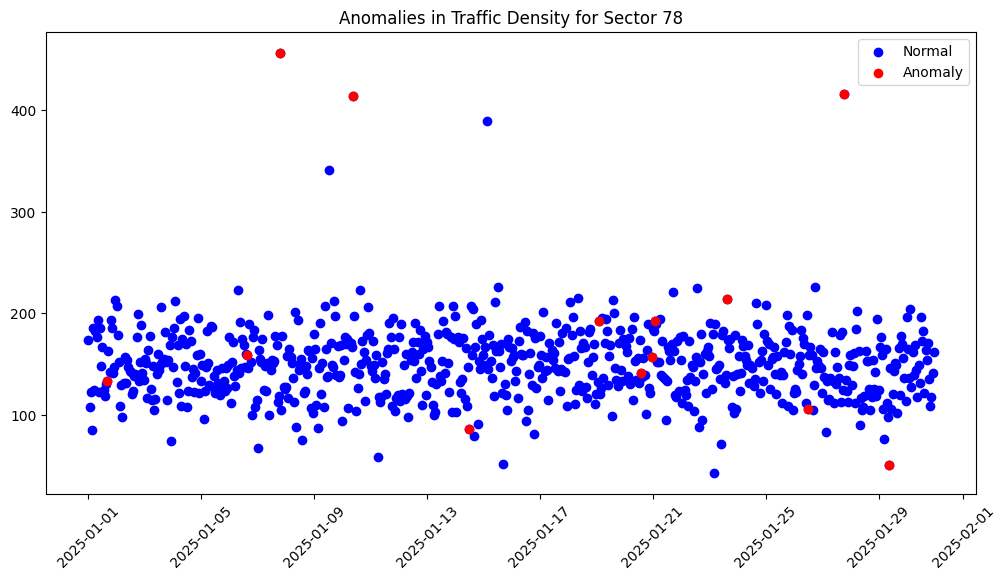

In [31]:
anomalies = df[df['iso_anomaly'] == -1]
highlight = anomalies[anomalies['zone'] == selected_zone]

plt.figure(figsize=(12, 6))
plt.scatter(zone_data['timestamp'], zone_data['traffic_density'], color='blue', label="Normal")
plt.scatter(highlight['timestamp'], highlight['traffic_density'], color='red', label="Anomaly")
plt.legend()
plt.xticks(rotation=45)
plt.title(f"Anomalies in Traffic Density for {selected_zone}")
plt.show()

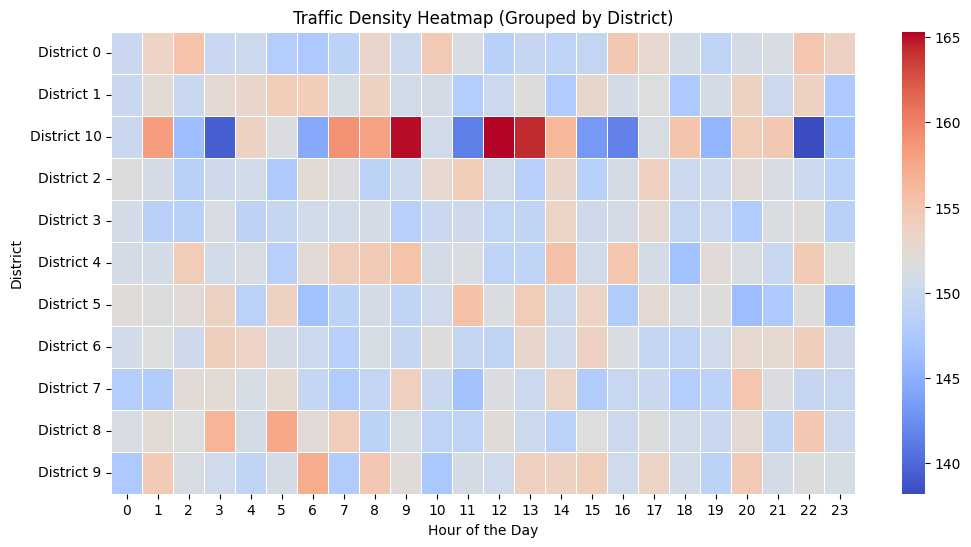

In [33]:
# Pivot data: Rows = zones, Columns = hours, Values = traffic_density
import seaborn as sns
df['district'] = df['zone'].apply(lambda x: f"District {int(x.split()[-1]) // 10}")
heatmap_data = df.pivot_table(index="district", columns="hour", values="traffic_density", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=0.5)
plt.title("Traffic Density Heatmap (Grouped by District)")
plt.xlabel("Hour of the Day")
plt.ylabel("District")
plt.show()


# 🚨 CityPulse – Part 6: Generating Alerts for High-Anomaly Zones

---

## 🎯 Goal

Now that we’ve detected anomalies across all sectors and time windows, let’s find out:
> ❗ Which zones are *most frequently* behaving abnormally?

We generate **human-readable alerts** when a zone crosses a certain anomaly threshold.

---

## 🔍 How It Works

1. **Count anomalies per zone**:  
   We count how many times each `zone` appears in our `anomalies` dataset (i.e., flagged by our model).

2. **Thresholding**:  
   If a zone has **more than 10 anomalies**, we consider it to be experiencing **abnormal urban behavior**.

3. **Print alerts**:  
   For each such zone, we print a message like:  
   > `🛑 Alert: Abnormal patterns detected in Sector 78`

---

## 📌 Why This Is Useful

- Helps highlight **hotspots of concern** — areas that consistently behave outside of normal patterns.
- A good way to **prioritize city responses**, e.g., send a traffic team or pollution monitor to that area.
- Works like a **real-time alert system** that would notify urban planners or control centers.

---

## 🛠️ Customize It

- Adjust the threshold (e.g., > 5 instead of > 10) based on your sensitivity.
- Send these alerts via **email**, **Slack**, or **SMS** in production.
- Combine alerts across metrics to identify **multi-sensor anomalies** (e.g., traffic + noise + pollution).

---

✅ This step connects raw anomaly detection to real-world **actionable insights**, which is the heart of the **CityPulse** system.


In [34]:
affected_zones = anomalies['zone'].value_counts()
top_alerts = affected_zones[affected_zones > 10].index.tolist()

for z in top_alerts:
    print(f"🛑 Alert: Abnormal patterns detected in {z}")

🛑 Alert: Abnormal patterns detected in Sector 78
🛑 Alert: Abnormal patterns detected in Sector 97
🛑 Alert: Abnormal patterns detected in Sector 79
🛑 Alert: Abnormal patterns detected in Sector 71
🛑 Alert: Abnormal patterns detected in Sector 85
🛑 Alert: Abnormal patterns detected in Sector 84
🛑 Alert: Abnormal patterns detected in Sector 68
🛑 Alert: Abnormal patterns detected in Sector 39
🛑 Alert: Abnormal patterns detected in Sector 28
🛑 Alert: Abnormal patterns detected in Sector 25
🛑 Alert: Abnormal patterns detected in Sector 69
🛑 Alert: Abnormal patterns detected in Sector 90


# 🌍 CityPulse – Part 7: Interactive Pollution Map with Folium

---

## 🎯 Goal

Visualize the **average air pollution (PM2.5)** levels across different city zones on a **live interactive map** using `folium`.

This helps you *see pollution geographically* rather than in tables or charts.

---

## 🧱 How It Works

1. **Map Setup**:
   - We use `folium.Map()` to create a base map centered on the city’s approximate latitude and longitude.
   - Zoom level `12` gives a city-wide view.

2. **Group Zones**:
   - We group the dataset by `zone` and calculate the **average** of:
     - Latitude
     - Longitude
     - PM2.5

   This gives us a single point and pollution value per zone.

3. **Add Circles**:
   - Each `zone` is represented as a **circle on the map**.
   - The color of the circle indicates air quality:
     - 🔴 Red → PM2.5 < 35 (generally poor)
     - 🟢 Green → PM2.5 ≥ 35 (cleaner air)

   *(You can flip or adjust this logic as needed based on local pollution thresholds.)*

4. **Popups**:
   - Clicking on any circle gives you a **popup** with:
     - Zone name
     - PM2.5 value

---

## 🧭 Why Use This?

- Helps spot **pollution clusters** in specific areas.
- City officials can use this map to:
  - Place air purifiers
  - Monitor industrial areas
  - Educate communities

- It's **interactive**, so users can zoom, pan, and explore intuitively.

---

## 🛠️ Customization Tips

- Use color gradients (e.g., green → yellow → red) for smoother visual transitions.
- Add more metrics: noise, power, traffic.
- Save the map to HTML using `.save("map.html")` to embed it in reports or websites.

---

✅ This map turns your sensor data into a powerful **geo-visual story** of air quality across the city.


In [35]:
import folium
import pandas as pd

# Load dataset
df = pd.read_csv("simulated_urban_sensor_data.csv")

# Create a base map centered around approximate city coordinates
m = folium.Map(location=[26.8, 83.4], zoom_start=12)

# Add zones to the map with color-coded pollution levels
for _, row in df.groupby('zone')[['lat', 'lon', 'pm2_5']].mean().reset_index().iterrows():
    folium.Circle(
        location=[row['lat'], row['lon']],
        radius=150,
        color="red" if row['pm2_5'] <35 else "green",  
        fill=True,
        fill_opacity=0.6,
        popup=f"Zone: {row['zone']} | PM2.5: {row['pm2_5']:.1f}"
    ).add_to(m)

m #.save("choropleth_map.html")  # Open in a browser

# 🗺️ CityPulse – Part 8: 3D Traffic Intensity Map with PyDeck

---

## 🎯 Goal

Visualize **traffic density** per city zone using an **interactive 3D map** created with `pydeck`.

This helps quickly identify which areas are experiencing more traffic, based on sensor data.

---

## 🧱 How It Works

### 1. Group By Zone
We group the dataset by `zone` and compute the **average**:
- Latitude (`lat`)
- Longitude (`lon`)
- Traffic density

This gives us one row per zone, with its average location and traffic level.

---

### 2. Define the Map View
We create a `ViewState` that:
- Centers the map at the **geographic center** of all zones.
- Sets a `zoom` level of 12 for a city-level view.

---

### 3. Create a PyDeck Layer

We use `ScatterplotLayer` to:
- Plot each zone as a **circle** on the map.
- Circle's **position** is set using `[lon, lat]`.
- Circle's **radius** is fixed (e.g., 200 meters).
- Circle's **color** is dynamic:
  - Red: `255`
  - Green: traffic density (scaled)
  - Blue: `100`

This means that zones with higher traffic will show a **more greenish tint**.

---

### 4. Render the Map

Finally, `pdk.Deck()` renders the map with:
- The defined layer
- The map view
- And saves the result to a file: `"scatter_map.html"`

You can **open this file in any browser** to interact with the map.

---

## 📌 Why Use This?

- You get an **instant geographic overview** of traffic intensity.
- Great for spotting **congested zones**.
- Easily extendable to other metrics like:
  - Noise levels
  - Pollution
  - Foot traffic

---

## 💡 Tips to Enhance

- Try using a **heatmap layer** for a smoother view.
- Add tooltips or labels for exact values.
- Animate the map over time to show traffic trends hourly.

---

✅ This visual brings your real-time sensor data to life — combining **space, intensity, and interaction** in one place.


In [36]:
import pydeck as pdk

zone_avg = df.groupby('zone')[['lat', 'lon', 'traffic_density']].mean().reset_index()

view_state = pdk.ViewState(latitude=zone_avg['lat'].mean(), longitude=zone_avg['lon'].mean(), zoom=12)

layer = pdk.Layer(
    "ScatterplotLayer",
    data=zone_avg,
    get_position=["lon", "lat"],
    get_radius=200,
    get_fill_color="[255, traffic_density, 100]",
)

pdk.Deck(layers=[layer], initial_view_state=view_state)#.to_html("scatter_map.html")

{
  "initialViewState": {
    "latitude": 26.761101204580374,
    "longitude": 83.37383792541327,
    "zoom": 12
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "lat": 26.769353770055524,
          "lon": 83.380140023651,
          "traffic_density": 149.57094591902901,
          "zone": "Sector 1"
        },
        {
          "lat": 26.78984239852998,
          "lon": 83.3562724949645,
          "traffic_density": 151.7742233019481,
          "zone": "Sector 10"
        },
        {
          "lat": 26.754811804614327,
          "lon": 83.34571929257363,
          "traffic_density": 151.43218269861126,
          "zone": "Sector 100"
        },
        {
          "lat": 26.800783434842973,
          "lon": 83.4182606779795,
          "traffic_density": 151.0496430744494,
          "zone": "Sector 11"
        },
        {
          "lat": 26.803510412246105,
          "lon": 83.37891300687703,
          "traffic_density": 152.86920351158108,
          "zone": "Sector 12"
        },
        {
          "lat": 26.80062219282112,
          "lon": 83.32395010388286,
          "traffic_density": 149.89799107056103,
          "zone": "Sector 13"
        },
        {
          "lat": 26.71808146744961,
          "lon": 83.36272419590092,
          "traffic_density": 150.73811518642626,
          "zone": "Sector 14"
        },
        {
          "lat": 26.74991943899562,
          "lon": 83.39173271087253,
          "traffic_density": 150.12828405141022,
          "zone": "Sector 15"
        },
        {
          "lat": 26.787289726546337,
          "lon": 83.40190185605792,
          "traffic_density": 152.97989914117764,
          "zone": "Sector 16"
        },
        {
          "lat": 26.78322630036035,
          "lon": 83.34818073490743,
          "traffic_density": 151.45463408657085,
          "zone": "Sector 17"
        },
        {
          "lat": 26.7334058387374,
          "lon": 83.34729532033121,
          "traffic_density": 150.4805994579316,
          "zone": "Sector 18"
        },
        {
          "lat": 26.74824374934384,
          "lon": 83.38980427977263,
          "traffic_density": 150.77810283055348,
          "zone": "Sector 19"
        },
        {
          "lat": 26.732833907161957,
          "lon": 83.39077293978369,
          "traffic_density": 151.84642570669743,
          "zone": "Sector 2"
        },
        {
          "lat": 26.718636402548,
          "lon": 83.37748644462954,
          "traffic_density": 149.88994469276597,
          "zone": "Sector 20"
        },
        {
          "lat": 26.730924265243694,
          "lon": 83.3895324529654,
          "traffic_density": 152.34619433479546,
          "zone": "Sector 21"
        },
        {
          "lat": 26.751849201108925,
          "lon": 83.40367274778578,
          "traffic_density": 150.55381255284001,
          "zone": "Sector 22"
        },
        {
          "lat": 26.79554741181069,
          "lon": 83.40506175697693,
          "traffic_density": 152.12665773402634,
          "zone": "Sector 23"
        },
        {
          "lat": 26.74981616105073,
          "lon": 83.37780040672877,
          "traffic_density": 149.60274675543934,
          "zone": "Sector 24"
        },
        {
          "lat": 26.770062814538107,
          "lon": 83.39610326821926,
          "traffic_density": 150.8626781543302,
          "zone": "Sector 25"
        },
        {
          "lat": 26.727200573535413,
          "lon": 83.34155397942577,
          "traffic_density": 150.471597365548,
          "zone": "Sector 26"
        },
        {
          "lat": 26.80333505536462,
          "lon": 83.33462809040539,
          "traffic_density": 149.75057446536604,
          "zone": "Sector 27"
        },
        {
          "lat": 26.803656219929653,
          "lon": 83.41708229577281,
          "traffic_density": 151.09599222117382,
          "zone": "Sector 28"
        },
        {
          "lat": 26.